In [34]:
letter="b"
band=1

import numpy as np
%config InlineBackend.rc = {}
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.utils.data import download_file
from astropy.io import fits
from matplotlib.colors import LogNorm
from photutils import CircularAperture
from astropy import units as u
from photutils import aperture_photometry
from photutils import CircularAnnulus
from photutils import EllipticalAnnulus
from math import sin, cos, pi
from photutils import EllipticalAperture

bandCorrectionFactor=[1.9350E-6,2.7048E-6,1.8326e-6,5.2269E-5]                    #Checked
#bandCorrectionFactor=[1,1,1,1]
bandFrequency=[2.99792e8/3.4e-6,2.99792e8/4.6e-6,2.99792e8/12e-6,2.99792e8/22e-6] #Checked
if band == 1:
    ChosenBandCorrectionFactor=bandCorrectionFactor[0]*bandFrequency[0]
elif band == 2:
    ChosenBandCorrectionFactor=bandCorrectionFactor[1]*bandFrequency[1]
elif band == 3:
    ChosenBandCorrectionFactor=bandCorrectionFactor[2]*bandFrequency[2]
elif band ==4: 
    ChosenBandCorrectionFactor=bandCorrectionFactor[3]*bandFrequency[3]
    
cycle=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
GalAPetRad=[9.6,3.2,6.3,8.9,10.3,6.2,10.5,10.3,18.2,39.5,44.4,51.3,42,6.6,9.25,100,12.5] #In arc seconds. One pixel =1.375"
GalAInc=[43,62,55,47,64,35,41,22,40,22,30,23,44,25,0,0,30] #TO BE REChecked (-90?)
GalAPA=[0,135,0,60,0,0,60,30,0,60,150,90,35,60,0,0,140]    #Checked
GalAPixCentreXVal=[221,220,219,214,215,227,219,225,219,219,202,219,219,220,219,100,219]
GalAPixCentreYVal=[209,219,219,223,235,226,220,212,219,219,219,219,219,219,219,100,219]
GalAMajAxis=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
GalAMinAxis=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
GalBPetRad=[2.5,11,7.7,2.5,11.3,7.2,10.3,10.3,15.3,68.4,68.4,68.4,2.5,10.3,17.7,18.0,100]
GalBInc=[40,49,73,40,65,33,56,32,49,11,11,11,41,32,0,0,45] #To be reChecked (-90?)
GalBPA=[0,30,0,0,0,0,0,58.2,40,55,55,55,0,58.2,0,45,0]     #Checked
GalBPixCentreXVal=[219,229,219,219,228,219,223,219,219,219,219,219,220,219,219,219,219]
GalBPixCentreYVal=[219,219,219,219,208,220,211,219,219,219,219,219,220,219,219,219,219]
GalBMajAxis=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
GalBMinAxis=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in cycle:
    GalAMajAxis[i-1]=(2*GalAPetRad[i-1])/1.375
    GalAMinAxis[i-1]=GalAMajAxis[i-1]*(cos((((GalAInc[i-1])*np.pi)/180)))
    GalBMajAxis[i-1]=(2*GalBPetRad[i-1])/1.375
    GalBMinAxis[i-1]=GalBMajAxis[i-1]*(cos((((GalBInc[i-1])*np.pi)/180)))
    
#print(GalAMajAxis)
#print(GalAMinAxis)

image_dataMin = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]  #Stores Mimimum Flux Value
image_dataPix = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]  #Stores number of pixels in each picture
image_dataAve = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]  #Stores average values of pixels in picture
image_dataMinAp = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]  #Stores Mimimum Flux Value in aperture
image_dataPixAp = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]  #Stores number of pixels in each aperture
image_dataAveAp = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]  #Stores average values of pixels in aperture
arrmgePic =     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
photsum = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
tot_table=[0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0]

#Finding background locally

Backgroundlevels=[]

for i in arrmgePic:
    image_file = '/mnt/alt43-XDrive/Physics/Projects/MPhys Projects/2016-17/Gas Dust Galaxies/All Data/WISE/%d%c/%d%c/%d%c/%d%cW%iPic.fits' % (i, letter, i, letter, i, letter, i, letter, band)
    hdu_list = fits.open(image_file)
    image_data = hdu_list[0].data
    hdu_list.close()
    image_dataMin[i-1]=np.min(image_data)
    print(np.min(image_data))
    pixels = image_data.shape[0]*image_data.shape[1]
    image_dataPix[i-1]=pixels
    flat_image = list(image_data.flat)
    total = 0
    for l in range(pixels):
        total = total + flat_image[l]
    Ave=total/pixels
    b=1
    
    if letter == 'a':
        
        ratioA=GalAMajAxis[i-1]/GalAMinAxis[i-1]
        #print("increment of major axis is:", ratioA)
        toprangeA=GalAMajAxis[i-1]+(2*ratioA)
        #print("Stop before major axis is:",  toprangeA)
        #print("Stop before minor is:", GalAMinAxis[i-1]+2)
        
        rad=ratioA
               
        while rad < toprangeA:
            position = [(GalAPixCentreXVal[i-1],GalAPixCentreYVal[i-1])]
            annulus_apertures = EllipticalAnnulus(position, a_in=rad-ratioA, a_out=rad, b_out=b, theta=((GalAPA[i-1])*(np.pi/180)))                   #Aperture at the position chosen
            image_dataAve[i-1] =Ave*ChosenBandCorrectionFactor
            data = image_data
            phot_table = aperture_photometry(data, annulus_apertures, method='subpixel', subpixels=10)
            annulus_area=annulus_apertures.area()
            photsum[i-1] = phot_table
            rad=rad+ratioA
            b=b+1
            if rad > toprangeA:
                annulus_apertures = EllipticalAnnulus(position, a_in=rad-ratioA, a_out=rad, b_out=b, theta=((GalAPA[i-1])*(np.pi/180)))                   #Aperture at the position chosen
                data = image_data
                phot_table = aperture_photometry(data, annulus_apertures, method='subpixel', subpixels=10)
                annulus_area=annulus_apertures.area()
                Backgroundlevels.append(((phot_table[0][0])/annulus_area))
    #Background levels found with correct areas for correct apertures/annuli
    else:
        
        ratioB=GalBMajAxis[i-1]/GalBMinAxis[i-1]
        #print("increment of major axis is:", ratioB)
        toprangeB=GalBMajAxis[i-1]+(2*ratioB)
        #print("Stop before major axis is:",  toprangeB)
        #print("Stop before minor is:", GalBMinAxis[i-1]+2)
        
        rad=ratioB
        
        while rad < toprangeB:
            position = [(GalBPixCentreXVal[i-1],GalBPixCentreYVal[i-1])]
            annulus_apertures = EllipticalAnnulus(position, a_in=rad-ratioB, a_out=rad, b_out=b, theta=((GalBPA[i-1])*(np.pi/180)))                   #Aperture at the position chosen
            image_dataAve[i-1]=Ave*ChosenBandCorrectionFactor
            data = image_data
            phot_table = aperture_photometry(data, annulus_apertures, method='subpixel', subpixels=10)
            annulus_area=annulus_apertures.area()
            photsum[i-1] = phot_table
            rad=rad+ratioB
            b=b+1
            if rad > toprangeB:
                annulus_apertures = EllipticalAnnulus(position, a_in=rad-ratioB, a_out=rad, b_out=b, theta=((GalBPA[i-1])*(np.pi/180)))                   #Aperture at the position chosen
                data = image_data
                phot_table = aperture_photometry(data, annulus_apertures, method='subpixel', subpixels=10)
                annulus_area=annulus_apertures.area()
                Backgroundlevels.append(((phot_table[0][0])/annulus_area))
  
    
print(Backgroundlevels)

4.64727


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


3.70793


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


2.73661


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


4.64727
3.29799


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


4.71966


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


3.80796


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


4.02906


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


3.4697
3.95771


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


3.95771


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


3.95771


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


5.13402


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


4.02906


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


3.72589


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


3.29749


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


3.57549


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


[13.406500099065834, 4.2308428615036178, 7.980958717397562, 13.406500099065834, 3.9489588375236124, 6.0181207299660588, 4.9389412778582029, 4.7499000731547243, 5.4010318623290123, 4.4988706479479079, 4.4988706479479079, 4.4988706479479079, 5.5580485646523705, 4.7499000731547243, 5.0368193021677561, 4.296794075807898, 4.8447927975879308]


#### In the cell above, ) galaxy inclinations are to be checked and cross-referenced with the SDSS/Westoby values to ensure they are correct. In many circumstances, it has been found that the given inclinations used in the calculation process to find major or minor axes are not suitable with the observed "shape" in the infrared bands. Readjusting the inclinations will be useful and viable if kept consistent. It is possible that this is a "90-inc" (~proper name,,,??~) issue. 
((((~Should PA angles be checked as were found roughly with substantial error for some!!!!!~))))

### Band correction factors (c found in the westoby site) are assumed to be correct for their corresponding bands, used to convert the data extracted from the FITS images from DN to janskys. Janskys are converted to flux using a frequency correction factor to manipulate the SI units. 

### Background radiation levels are found in an aperture that lies just outside of the galaxy by assuring that the top background radii (toprangeA/B) are beyond the maximum radii by adding (2*ratio)* or the incrementing amount for the major axes. The pixel values are summed in this annulus and divided by its are to find the average background value of radiation surrounding the galaxy. *Local background levels*



17.10151809916634 5
This is galaxy: 3


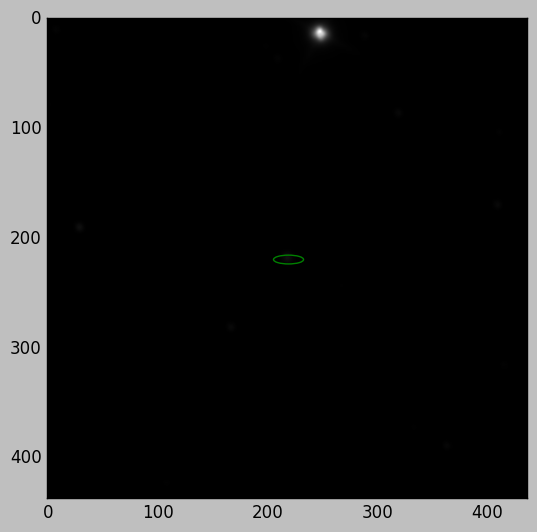

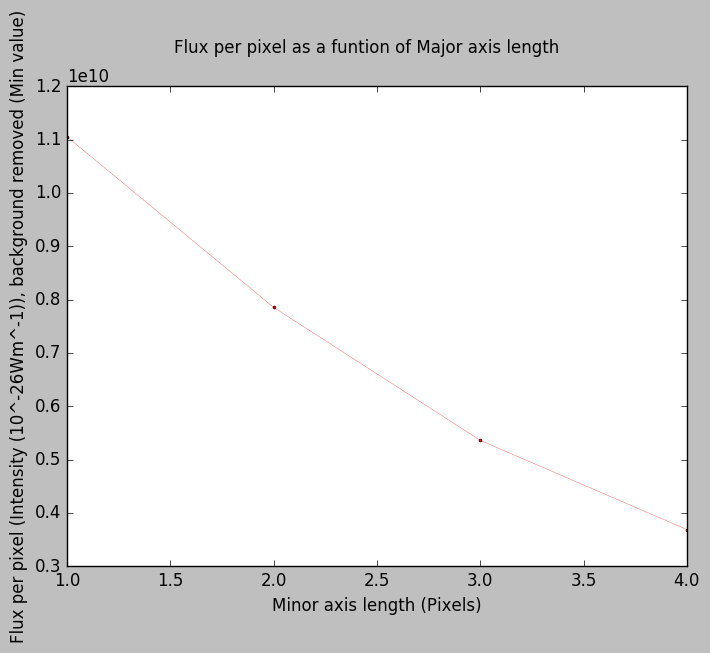

[3689400502.0782471]


In [35]:
#Graphs of Flux per pixel vs radius
FluxPerPixelInLargestAperture=[]

for i in range(3,4): #arrmgePic:
    image_file = '/mnt/alt43-XDrive/Physics/Projects/MPhys Projects/2016-17/Gas Dust Galaxies/All Data/WISE/%d%c/%d%c/%d%c/%d%cW%iPic.fits' % (i, letter, i, letter, i, letter, i, letter, band)
    hdu_list = fits.open(image_file)
    image_data = hdu_list[0].data
    hdu_list.close()
    image_dataMin[i-1]=np.min(image_data)
    pixels = image_data.shape[0]*image_data.shape[1]
    image_dataPix[i-1]=pixels
    flat_image = list(image_data.flat)
    total = 0
    for l in range(pixels):
        total = total + flat_image[l]
    Ave=total/pixels
    RadArray=[]
    FluxAtRad=[]
    b=1
    
    if letter == 'a':
        ratioA=GalAMajAxis[i-1]/GalAMinAxis[i-1]
        #print("increment of major axis is:", ratioA)
        toprangeA=GalAMajAxis[i-1]+ratioA
        #print("Stop before major is:",  toprangeA)
        #print("Stop before minor is:", GalAMinAxis[i-1]+1)
        
        rad=ratioA
        
        while rad < toprangeA:
            
            #print("major is:", rad)
            #print("minor is:", b)
            #print( )
            
            position = [(GalAPixCentreXVal[i-1],GalAPixCentreYVal[i-1])] #Aperture centre around the image centre
            apertures = EllipticalAperture(position, a=rad, b=b, theta=((GalAPA[i-1])*(np.pi/180)))                   #Aperture at the position chosen
            image_dataAve[i-1]=Ave*ChosenBandCorrectionFactor
            data = image_data
            phot_table = aperture_photometry(data, apertures, method='subpixel', subpixels=10)
            photsum[i-1] = phot_table
            FluxAtRad.append(((phot_table[0][0]/(apertures.area()))-Backgroundlevels[i-1])*ChosenBandCorrectionFactor)    #Subtracts the background level
            a=apertures.area()
            RadArray.append(b)
            rad=rad+ratioA
            b=b+1
            plt.figure(1)
            plt.imshow(image_data, cmap='gray')
            if b % 10 == 0:
                apertures.plot(color='green')
            #print(phot_table[0][0])
            #print(apertures.area())
        #print(RadArray)
        #print(FluxAtRad)
    
    else:
        ratioB=GalBMajAxis[i-1]/GalBMinAxis[i-1]
        #print("increment of major axis is:", ratioB)
        toprangeB=GalBMajAxis[i-1]+ratioB
        #print("Stop before major is:",  toprangeB)
        #print("Stop before minor is:", GalBMinAxis[i-1]+1)
        
        rad=ratioB
        
        while rad < toprangeB:
            
            #print("major is:", rad)
            #print("minor is:", b)
            #print( )
                        
            position = [(GalBPixCentreXVal[i-1],GalBPixCentreYVal[i-1])] #Aperture centre around the image centre
            apertures = EllipticalAperture(position, a=rad, b=b, theta=((GalBPA[i-1])*(np.pi/180)))                   #Aperture at the position chosen
            image_dataAve[i-1]=Ave*ChosenBandCorrectionFactor
            data = image_data
            phot_table = aperture_photometry(data, apertures, method='subpixel', subpixels=10)
            photsum[i-1] = phot_table
            FluxAtRad.append(((phot_table[0][0]/(apertures.area()))-Backgroundlevels[i-1])*ChosenBandCorrectionFactor)    #Subtracts the background level
            a=apertures.area()
            RadArray.append(b)
            rad=rad+ratioB
            b=b+1
            plt.figure(1)
            plt.imshow(image_data, cmap='gray')
            if b % 5 == 0:
                apertures.plot(color='green')
        #print(RadArray)
        #print(FluxAtRad[-1])
    print(rad, b)
    FluxPerPixelInLargestAperture.append(FluxAtRad[-1])
    
    print("This is galaxy:", i)
    plt.figure(2)
    y1 = FluxAtRad
    x = RadArray
    #plt.errorbar(x, y1, xerr=(0.5, 0.7, 5.2, 3), ecolor='black', capthick=1.0, lw=1)
    line = plt.plot(x, y1, 'ro-', linewidth=0.2, ms=2)
    plt.suptitle('Flux per pixel as a funtion of Major axis length')
    plt.xlabel('Minor axis length (Pixels)')
    plt.ylabel('Flux per pixel (Intensity (10^-26Wm^-1)), background removed (Min value)')
    labels=RadArray
    plt.show()

print(FluxPerPixelInLargestAperture)

#### Flux per pixel is found with elliptical apertures extending out from the centre at a constant axis ratio with designated inclination and PA. The total intensity of the aperture is found and then divided by the aperture area before subtracting the background levels which were previously calaculated for an annulus aperture surrounding the outer edge of the galaxy but outside of the agreed maximum major axis value by a (2*ratio*) value. 
*(Possible that centre values may need to be adjusted, galaxy 3b currently demonstrates this # was the one printed to show carole the terrible match of galactic shape and aperture)*
### 

/home/alt43/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


[118796551200.83701, 337642438234.15485, 518585461267.87769, 634293583202.71985]
[1, 2, 3, 4]
This is galaxy: 3


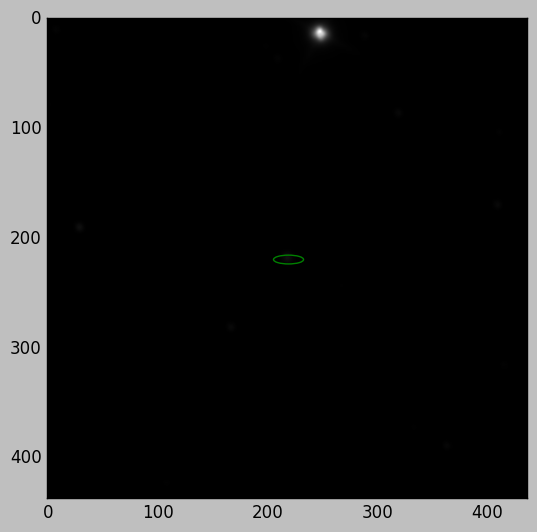

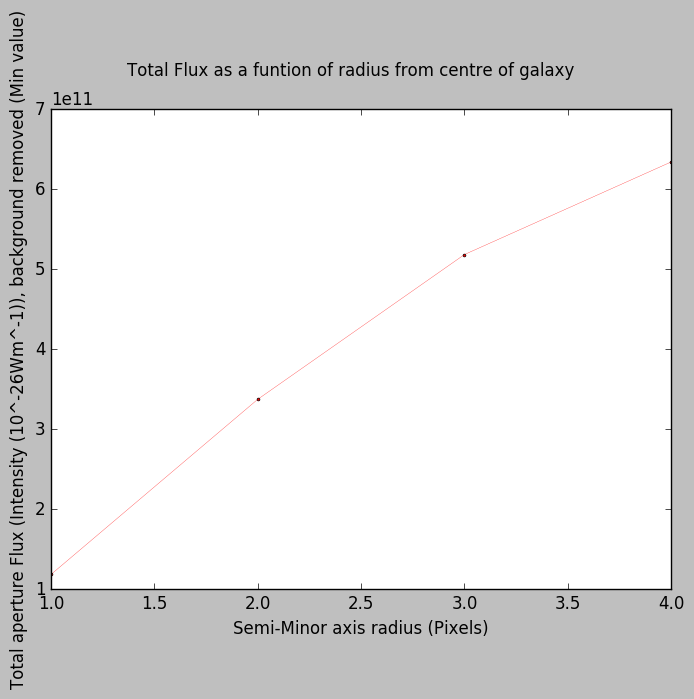

[1.9075400000040292]


In [42]:
#Graphs of Total Flux vs radius
FluxPerPixelArray=[]
EffRadArray=[]
for i in range(3,4):# arrmgePic:
    image_file = '/mnt/alt43-XDrive/Physics/Projects/MPhys Projects/2016-17/Gas Dust Galaxies/All Data/WISE/%d%c/%d%c/%d%c/%d%cW%iPic.fits' % (i, letter, i, letter, i, letter, i, letter, band)
    hdu_list = fits.open(image_file)
    image_data = hdu_list[0].data
    hdu_list.close()
    image_dataMin[i-1]=np.min(image_data)
    pixels = image_data.shape[0]*image_data.shape[1]
    image_dataPix[i-1]=pixels
    flat_image = list(image_data.flat)
    total = 0
    for l in range(pixels):
        total = total + flat_image[l]
    Ave=total/pixels
    
    RadArray=[]
    FluxAtRad=[]
    b=1
    
    if letter == 'a':
        ratioA=GalAMajAxis[i-1]/GalAMinAxis[i-1]
        #print("increment of major axis is:", ratioA)
        toprangeA=GalAMajAxis[i-1]+ratioA
        #print("Stop before major axis is:",  toprangeA)
        #print("Stop before minor is:", GalAMinAxis[i-1]+1)
        
        rad=ratioA
        
        while rad < toprangeA: ##########Needs to be changed back
            
            #print("major is:", rad)
            #print("minor is:", b)
            #print( )
            
            position = [(GalAPixCentreXVal[i-1],GalAPixCentreYVal[i-1])] #Aperture centre around the image centre
            apertures = EllipticalAperture(position, a=rad, b=b, theta=((GalAPA[i-1])*(np.pi/180)))                   #Aperture at the position chosen
            image_dataAve[i-1]=Ave*ChosenBandCorrectionFactor
            data = image_data
            phot_table = aperture_photometry(data, apertures, method='subpixel', subpixels=10)
            photsum[i-1] = phot_table
            FluxAtRad.append(((phot_table[0][0]-((apertures.area())*Backgroundlevels[i-1]))*ChosenBandCorrectionFactor))   #Subtracts the background level
            a=apertures.area()
            RadArray.append(b)
            rad=rad+ratioA            
            b=b+1
            plt.figure(1)
            plt.imshow(image_data, cmap='gray')
            if b % 5 == 0:
                apertures.plot(color='green')
    else:
        ratioB=GalBMajAxis[i-1]/GalBMinAxis[i-1]
        #print("increment of major axis is:", ratioB)
        toprangeB=GalBMajAxis[i-1]+ratioB
        #print("Stop before major is:",  toprangeB)
        #print("Stop before minor is:", GalBMinAxis[i-1]+1)
        
        rad=ratioB
        
        while rad < toprangeB:
            
            #print("major is:", rad)
            #print("minor is:", b)
            print( )
                        
            position = [(GalBPixCentreXVal[i-1],GalBPixCentreYVal[i-1])] #Aperture centre around the image centre
            apertures = EllipticalAperture(position, a=rad, b=b, theta=((GalBPA[i-1])*(np.pi/180)))                   #Aperture at the position chosen
            image_dataAve[i-1]=Ave*ChosenBandCorrectionFactor
            data = image_data
            phot_table = aperture_photometry(data, apertures, method='subpixel', subpixels=10)
            photsum[i-1] = phot_table
            FluxAtRad.append(((phot_table[0][0]-((apertures.area())*Backgroundlevels[i-1]))*ChosenBandCorrectionFactor))   #Subtracts the background level
            a=apertures.area()
            RadArray.append(b)
            rad=rad+ratioB
            b=b+1
            plt.figure(1)
            plt.imshow(image_data, cmap='gray')
            if b % 5 == 0:
                apertures.plot(color='green')
                
    fit=0
    fit=np.polyfit(RadArray, FluxAtRad, 12)
    effrad=1e-5
    answer=0
    while answer <= ((FluxAtRad[-1])/2):
        answer = ((fit[0]*(effrad**12))+(fit[1]*(effrad**11))+(fit[2]*(effrad**10))+(fit[3]*(effrad**9))+(fit[4]*(effrad**8))+(fit[5]*(effrad**7))+(fit[6]*(effrad**6))+(fit[7]*(effrad**5))+(fit[8]*(effrad**4))+(fit[9]*(effrad**3))+(fit[10]*(effrad**2))+(fit[11]*(effrad**1))+(fit[12]))
        effrad=effrad+1e-5
    EffRadArray.append(effrad)
    
        
    FluxPerPixelArray.append((FluxAtRad[-1]))
    
    print(FluxAtRad)
    print(RadArray)
    
    print("This is galaxy:", i)
    plt.figure(2)
    y1 = FluxAtRad
    x=RadArray
    #plt.errorbar(x, y5A, xerr=(0.5, 0.7, 5.2, 3), ecolor='black', capthick=1.0, lw=1)
    line = plt.plot(x, y1, 'ro-', linewidth=0.2, ms=2)
    plt.suptitle('Total Flux as a funtion of radius from centre of galaxy')
    plt.xlabel('Semi-Minor axis radius (Pixels)')
    plt.ylabel('Total aperture Flux (Intensity (10^-26Wm^-1)), background removed (Min value)')
    plt.show()

    
print(EffRadArray)

    
#print(FluxPerPixelArray)
#print ("Minimums (B) are:", (image_dataMin))
#print ( )
#print ("Pixels are:", (image_dataPix))
#print ( )
#print ("Averages within aperture are:" ,(image_dataAve))

#### The total flux is collect and a background value is subtracted for the total number of pixels in the elliptical aperture, which extends out from the centre in the same way as it does when finding flux per pixel. 

increment of major axis is: 1.3054072893322786
Stop before major is: 4.941770925695915
Stop before minor is: 3.7856161567962836
[-1318953914.7422364, -1320683989.5673218, -1299189688.2681353, -1247524621.571306]
This is galaxy: 1


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


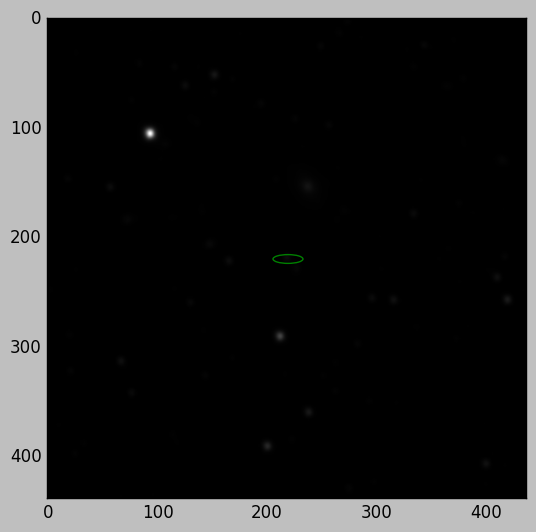

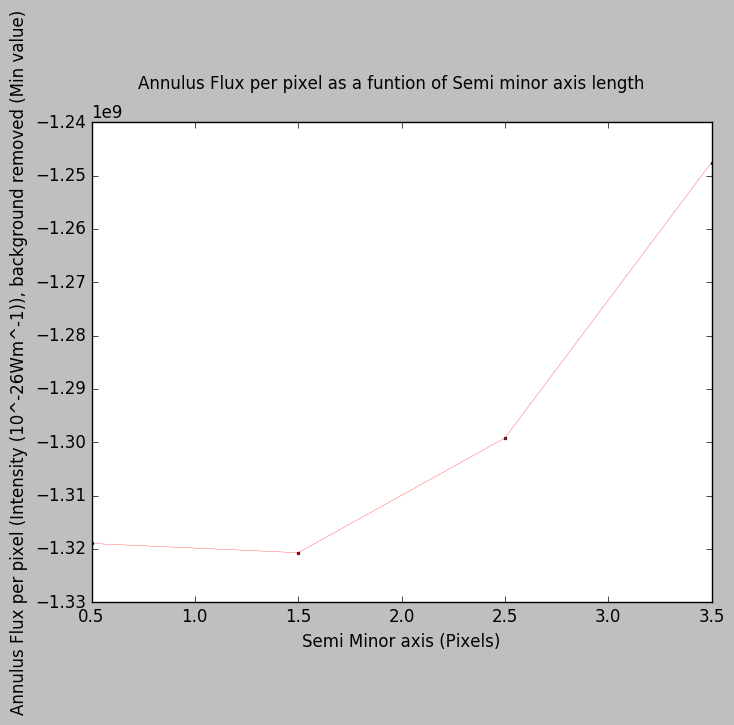

increment of major axis is: 1.5242530867058142
Stop before major is: 17.524253086705816
Stop before minor is: 11.496944463848116
[546212300.17885256, 633267262.61232114, 773399735.77311134, 993186298.88722551, 1238376620.583147, 1490884544.2391267, 1660333741.6893437, 1670734400.7226236, 1500328160.8252873, 1204432010.0496111, 871951307.09684336, 578114076.40025318, 361565780.87312013, 215171616.80696478, 125044967.00397938]
This is galaxy: 2


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


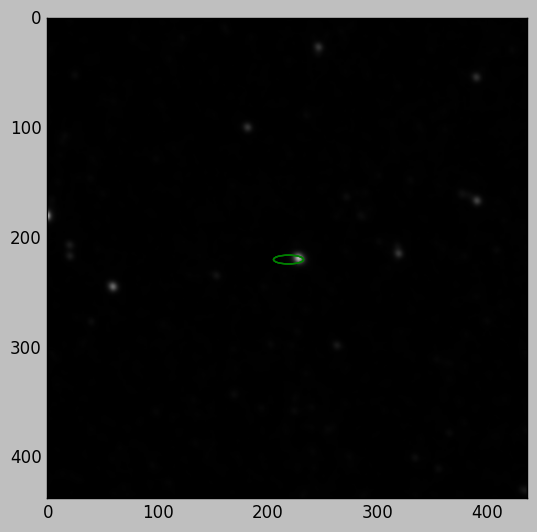

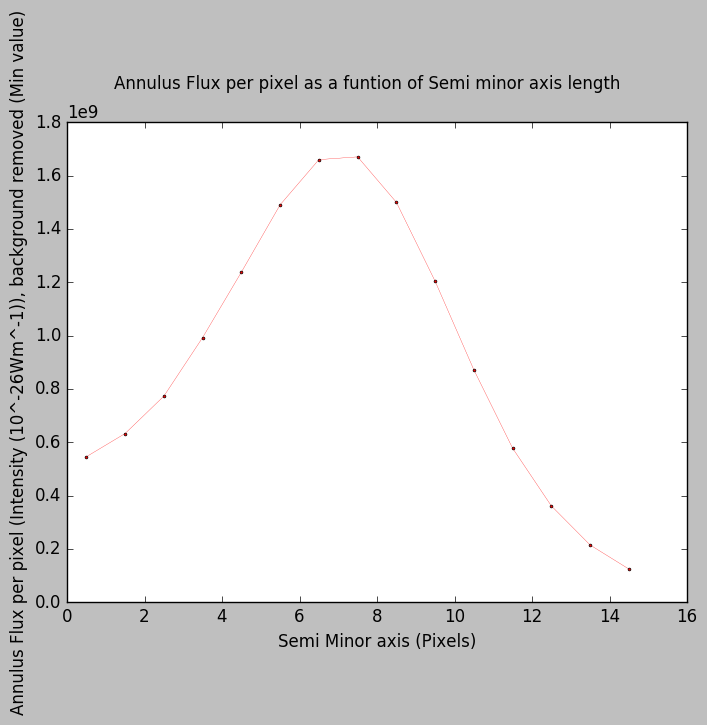

increment of major axis is: 3.4203036198332684
Stop before major is: 14.620303619833269
Stop before minor is: 4.2745630928946525
[11055777759.755913, 9585492807.465723, 7767213386.2973623, 5857531824.5507727, 4043010452.8597307, 2579387330.0975232, 1478247340.8232415, 700634297.80879807, 182890476.15339607, -160931440.80987966, -378594721.53110689]
This is galaxy: 3


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


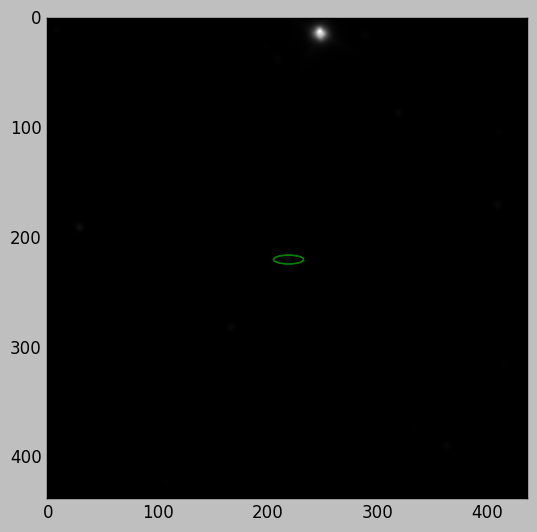

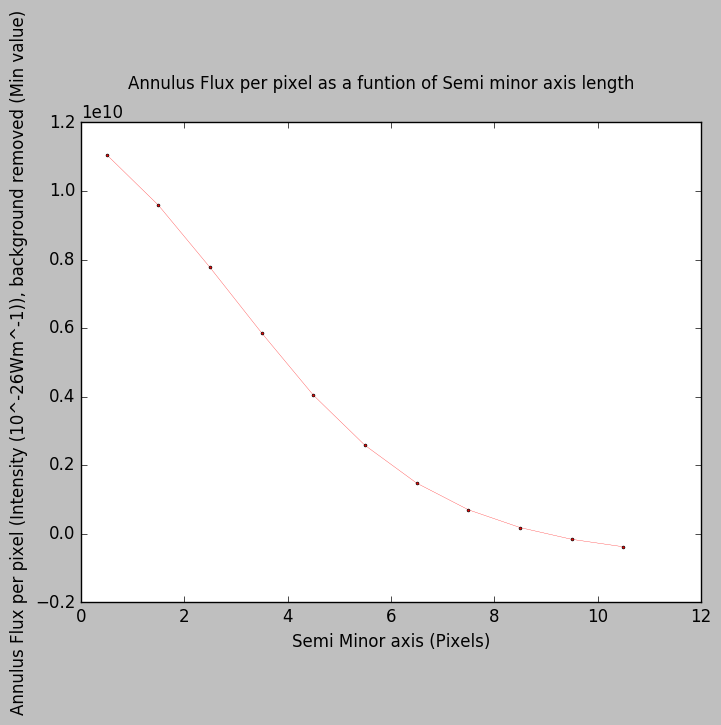

increment of major axis is: 1.3054072893322786
Stop before major is: 4.941770925695915
Stop before minor is: 3.7856161567962836
[-636072891.76893318, -565740643.10475886, -416436319.85730106, -228669240.97823805]
This is galaxy: 4


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


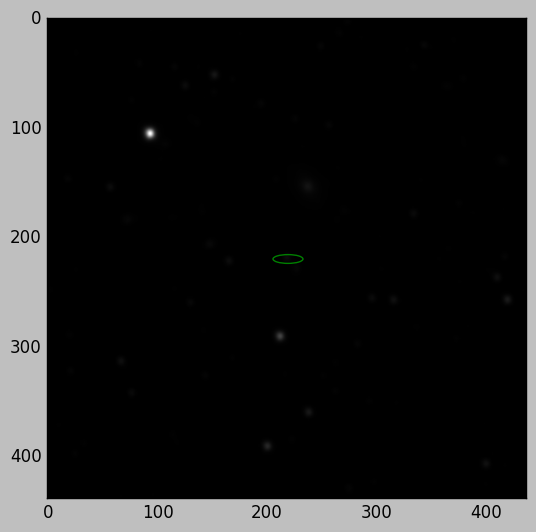

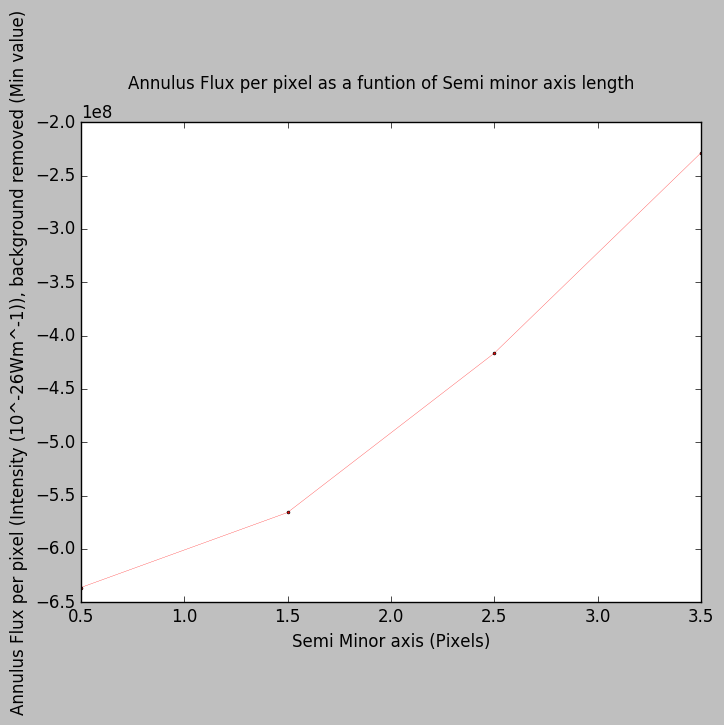

increment of major axis is: 2.3662015831524985
Stop before major is: 18.802565219516136
Stop before minor is: 7.9463074293380425
[-73868674.770745561, -73245878.183708727, -70094705.32531105, -69669137.202706069, -67309140.274874851, -67494346.730797142, -65080417.170780413, -61622735.524056144, -60662753.058670066, -60678979.137754388, -60461101.463016987, -59467966.698527358, -59270250.534281276, -59318171.845059961, -57925813.673445545, -58071267.080113977]
This is galaxy: 5


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


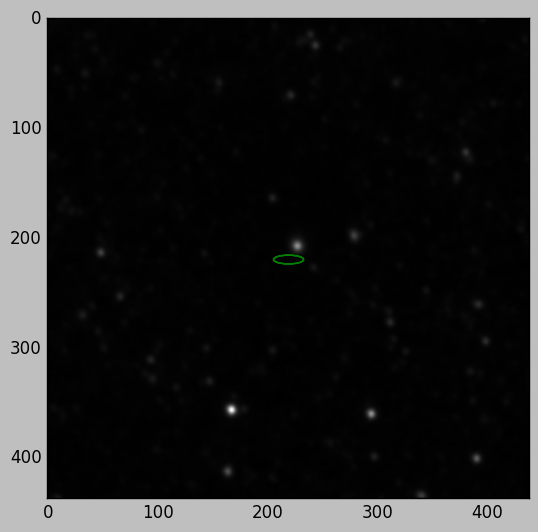

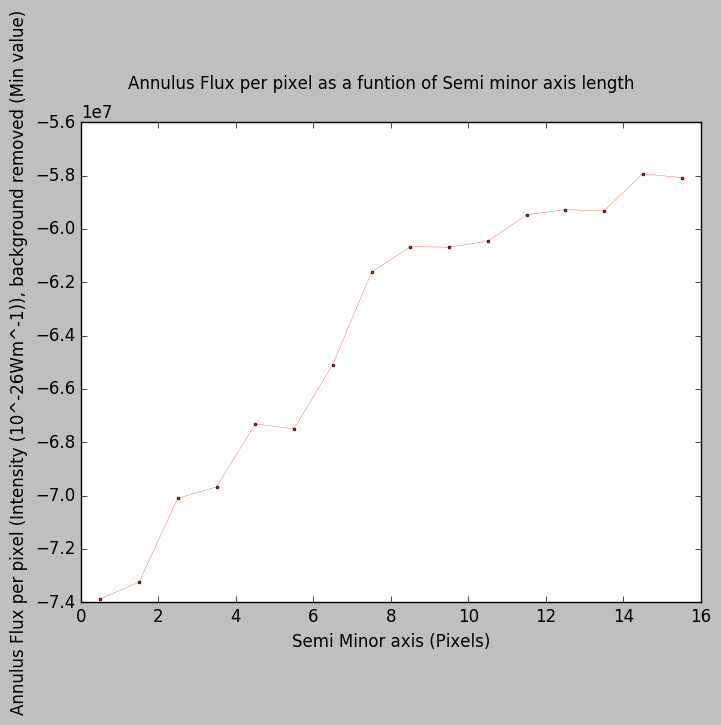

increment of major axis is: 1.1923632928359473
Stop before major is: 11.66509056556322
Stop before minor is: 9.783168129755714
[-27612640.497076578, -31720376.591114268, -40809640.080450132, -24955787.299323533, 12507831.427544361, 74452990.058127925, 149556804.89239088, 261419523.6894978, 374405719.20183969, 464037738.9674421]
This is galaxy: 6


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


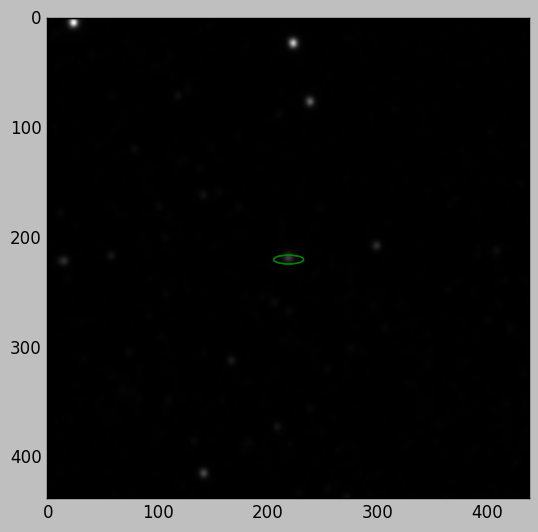

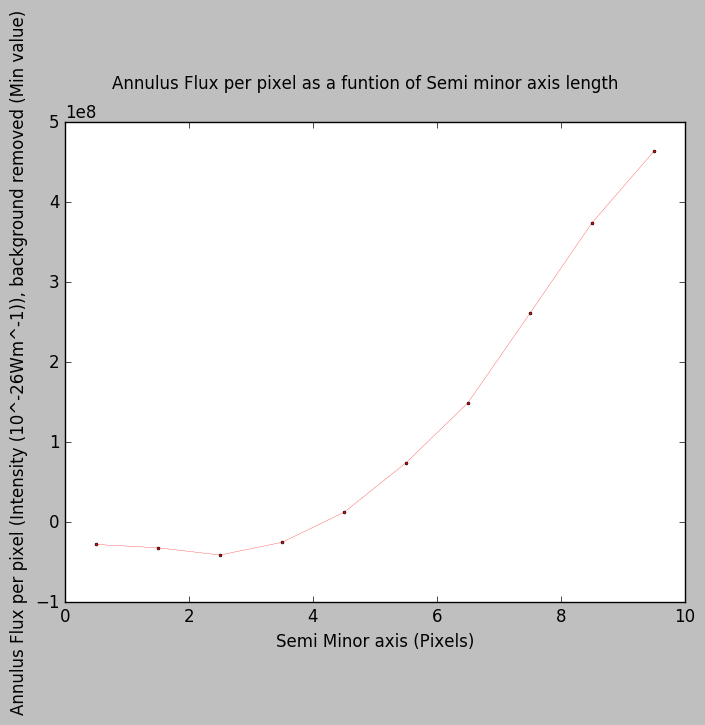

increment of major axis is: 1.7882916499714006
Stop before major is: 16.770109831789583
Stop before minor is: 9.377726408361735
[494716390.26098692, 466191911.15051723, 460230656.16943836, 445923105.62603402, 456617123.36681342, 479097404.44402814, 510537461.03433871, 530353225.27538735, 551762507.26859725, 540083664.84555161, 494260744.18536335, 423699360.77689701, 337854909.49872661, 248929603.45429137]
This is galaxy: 7


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


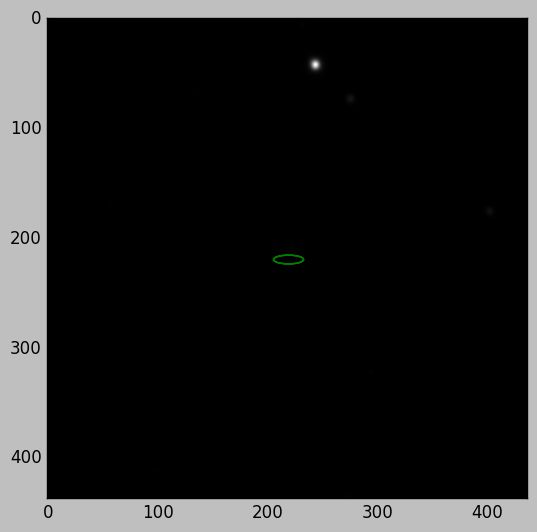

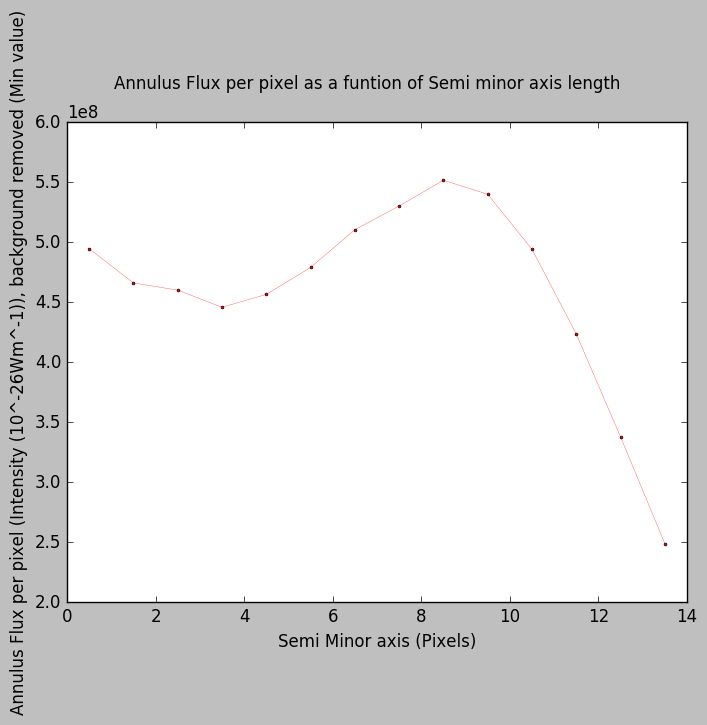

increment of major axis is: 1.1791784033620965
Stop before major is: 16.16099658518028
Stop before minor is: 13.705302386052637
[290958867.01997846, 333418822.88045424, 349007516.18880254, 396311365.30615681, 441824698.31877601, 482092379.96042418, 506397748.62000024, 508200325.69501656, 489805465.23822814, 450180513.9589318, 386316659.40833861, 305993762.06233543, 230915782.86142981, 170546005.22830981]
This is galaxy: 8


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


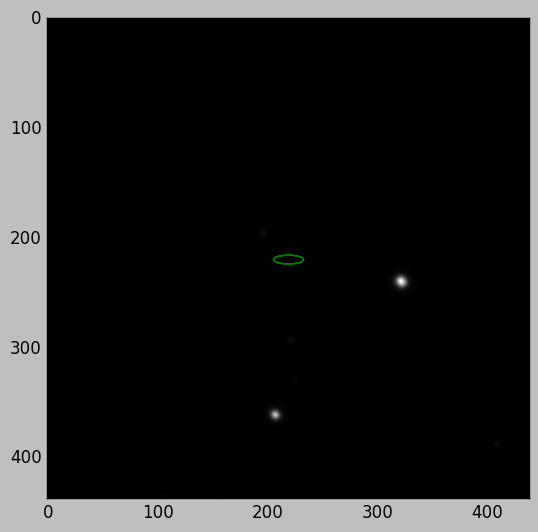

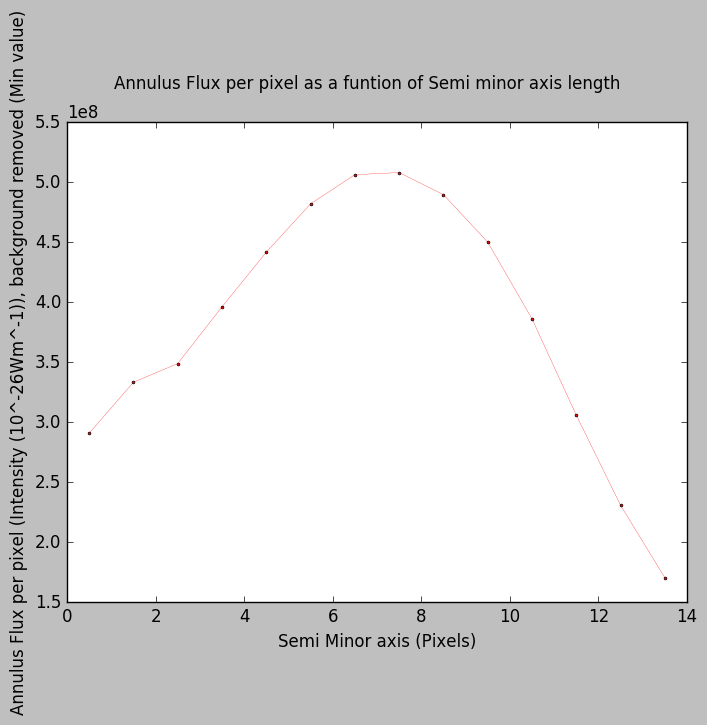

increment of major axis is: 1.5242530867058142
Stop before major is: 23.77879854125127
Stop before minor is: 15.600295481534198
[15101337634.315298, 13875160434.705912, 11763001697.005461, 9472356809.0529652, 7195200823.0822334, 5300505912.7577639, 3858510237.2032118, 2786173517.4255872, 2016144979.1617358, 1444175650.5377126, 1055795332.0441359, 768133231.26527369, 561532273.09777367, 407440821.90005386, 290246239.83378696, 198876514.1159361, 128190214.98297416, 72355075.029851556, 23210336.90872914, -9864749.3030135464, -35759120.017316982]
This is galaxy: 9


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


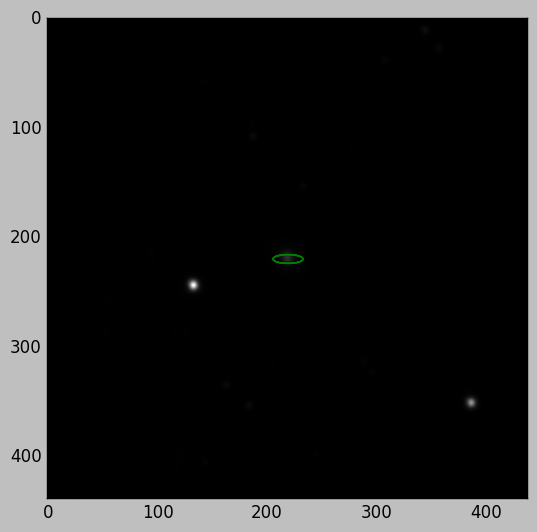

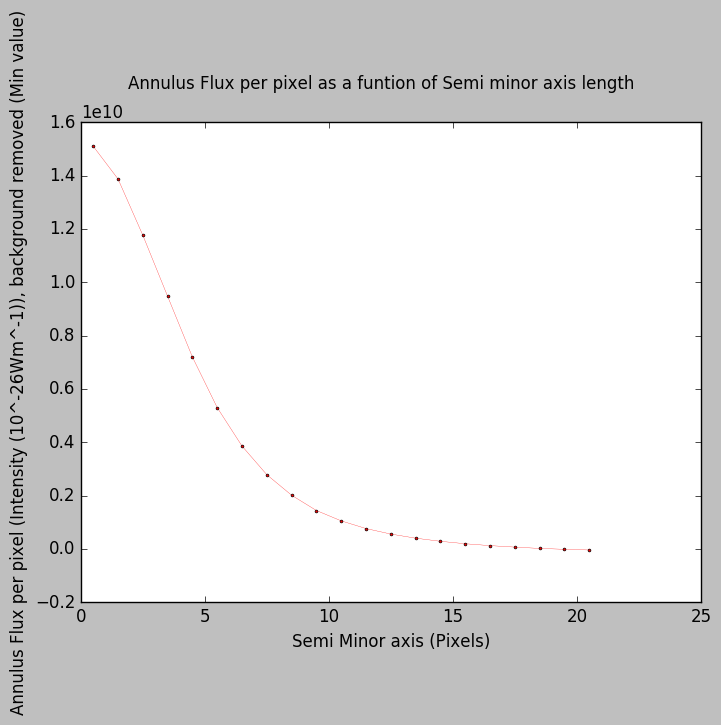

increment of major axis is: 1.0187166949552142
Stop before major is: 100.50962578586432
Stop before minor is: 98.66298086955669


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


[25017964613.56168, 23381936262.247913, 20850329336.833214, 17908300351.510529, 15120446952.493105, 12636280203.081415, 10859026223.856995, 9473958245.2766247, 8458560401.7814407, 7642340305.5167675, 7065861483.7228746, 6601300145.6848078, 6197765611.3960924, 5875767460.3388615, 5586101096.8652678, 5308496993.2386246, 5035893975.8005238, 4797965227.0438585, 4563233502.9514475, 4296829536.3957386, 4030247862.5765505, 3793756335.2165656, 3569903396.3525882, 3338618099.4442773, 3110521832.4089236, 2902036066.2373147, 2709118991.2589588, 2524003408.6201224, 2346486502.9765396, 2185739648.0052843, 2030456174.4203362, 1891164078.536217, 1756831073.308814, 1643156487.3826609, 1540674625.1957934, 1448358079.4886041, 1363824990.5977414, 1269619225.7369783, 1178448450.3091719, 1085399718.675236, 1004524110.7131194, 921702040.20165491, 845035223.79795599, 774530844.1484803, 713702237.35836184, 661069495.37946188, 610892062.20442009, 567832273.476758, 531574697.83996594, 499865585.88530976, 470586

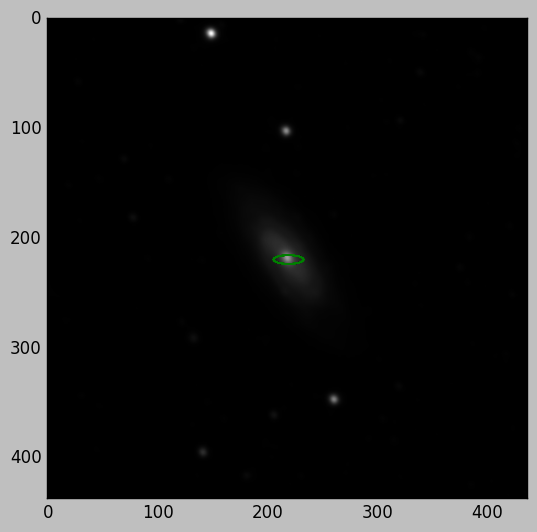

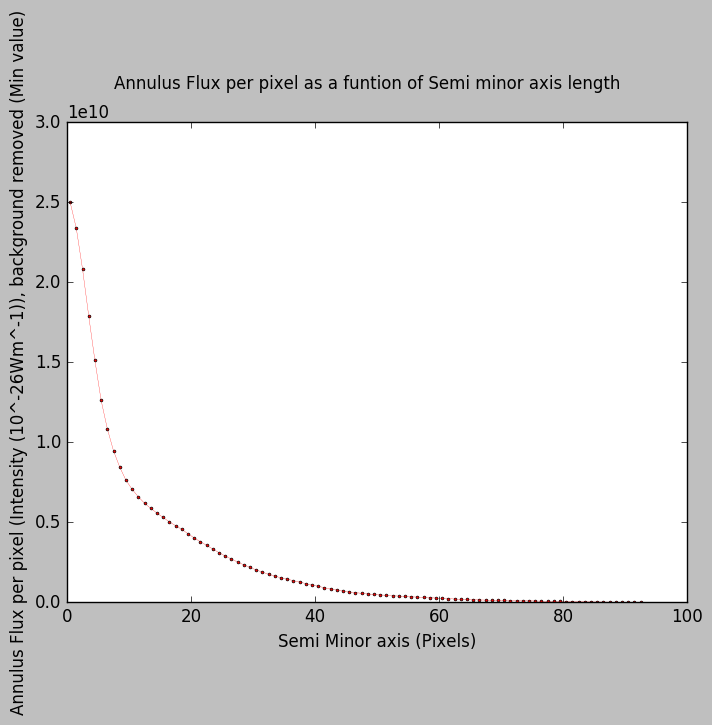

increment of major axis is: 1.0187166949552142
Stop before major is: 100.50962578586432
Stop before minor is: 98.66298086955669


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


[4263156151.5698428, 4240058960.1231213, 4275071781.3613687, 4330358682.3685532, 4401734247.7774858, 4441245477.1198816, 4551557161.442729, 4646730001.1390905, 4765154374.3007679, 4883880397.1684313, 5094589348.9073191, 5352174953.8954868, 5598205519.9678144, 5826652968.2120914, 5972064391.7847385, 5948225926.0974255, 5735684828.3517962, 5413415211.6663742, 5032254064.6492243, 4611483000.5583096, 4209443998.3026433, 3888729593.1228428, 3617910918.6939039, 3378155414.9742289, 3167294661.5347948, 3006045355.2135739, 2871641038.0925288, 2749072220.682199, 2629523525.7569337, 2516744588.6853495, 2386825588.6378608, 2248385132.1634402, 2101046729.1271849, 1963755080.9070406, 1828138037.3691316, 1699373264.3299253, 1587757570.3937564, 1479204880.7888582, 1384864967.8090584, 1297008811.7189639, 1229238080.8045228, 1161687533.6534657, 1099206249.6790237, 1039464677.2209208, 987276969.30264854, 938166839.68499601, 885704976.13238215, 832838609.96086252, 781304054.99965739, 727872520.12516618, 6

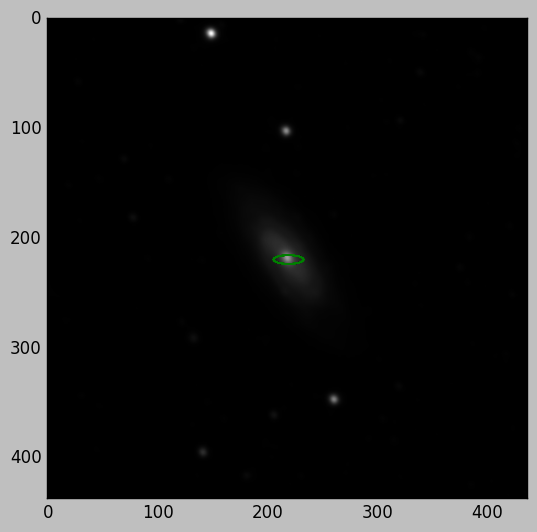

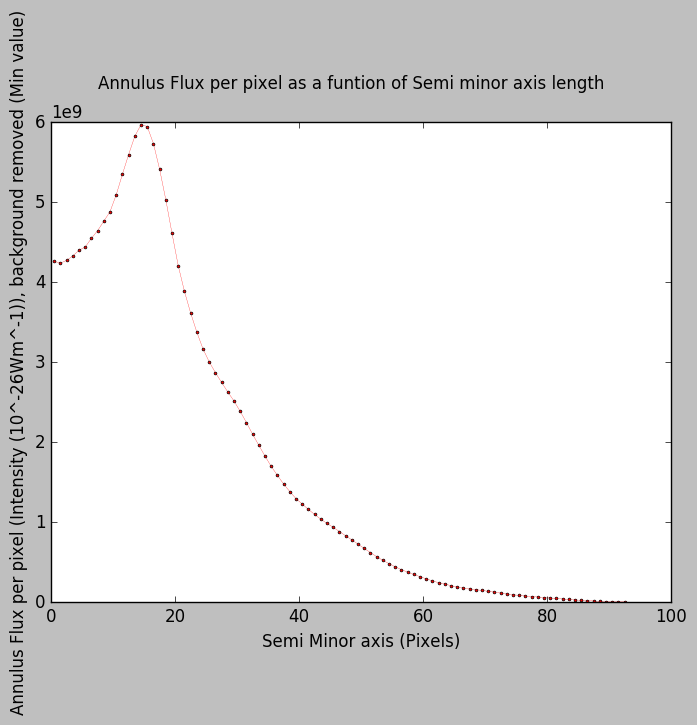

increment of major axis is: 1.0187166949552142
Stop before major is: 100.50962578586432
Stop before minor is: 98.66298086955669


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


[25017964613.56168, 23381936262.247913, 20850329336.833214, 17908300351.510529, 15120446952.493105, 12636280203.081415, 10859026223.856995, 9473958245.2766247, 8458560401.7814407, 7642340305.5167675, 7065861483.7228746, 6601300145.6848078, 6197765611.3960924, 5875767460.3388615, 5586101096.8652678, 5308496993.2386246, 5035893975.8005238, 4797965227.0438585, 4563233502.9514475, 4296829536.3957386, 4030247862.5765505, 3793756335.2165656, 3569903396.3525882, 3338618099.4442773, 3110521832.4089236, 2902036066.2373147, 2709118991.2589588, 2524003408.6201224, 2346486502.9765396, 2185739648.0052843, 2030456174.4203362, 1891164078.536217, 1756831073.308814, 1643156487.3826609, 1540674625.1957934, 1448358079.4886041, 1363824990.5977414, 1269619225.7369783, 1178448450.3091719, 1085399718.675236, 1004524110.7131194, 921702040.20165491, 845035223.79795599, 774530844.1484803, 713702237.35836184, 661069495.37946188, 610892062.20442009, 567832273.476758, 531574697.83996594, 499865585.88530976, 470586

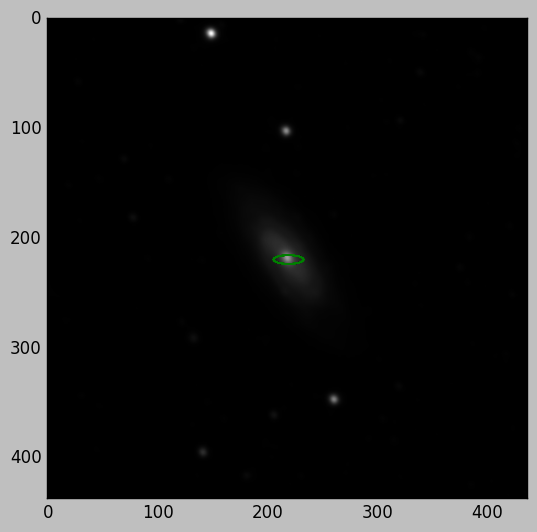

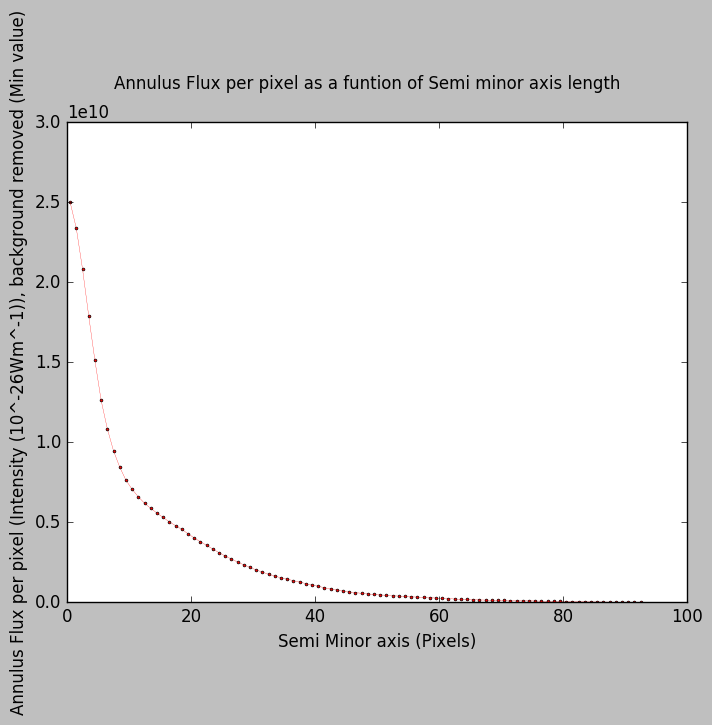

increment of major axis is: 1.325012993348811
Stop before major is: 4.961376629712447
Stop before minor is: 3.7443984735373532
[25829521.293204181, 24399169.098388109, 5273398.2322858553, 9369501.3126168773]
This is galaxy: 13


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


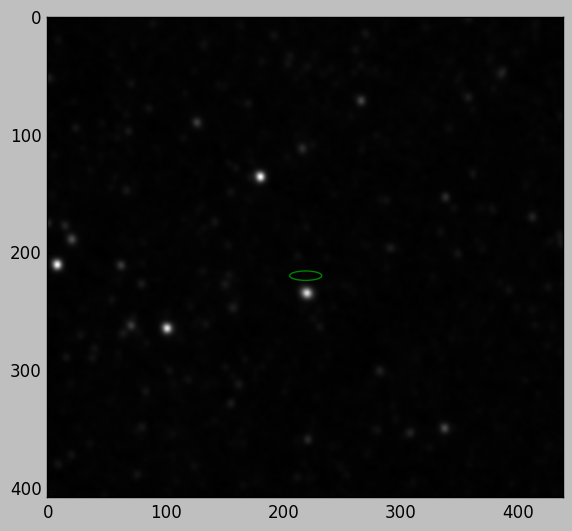

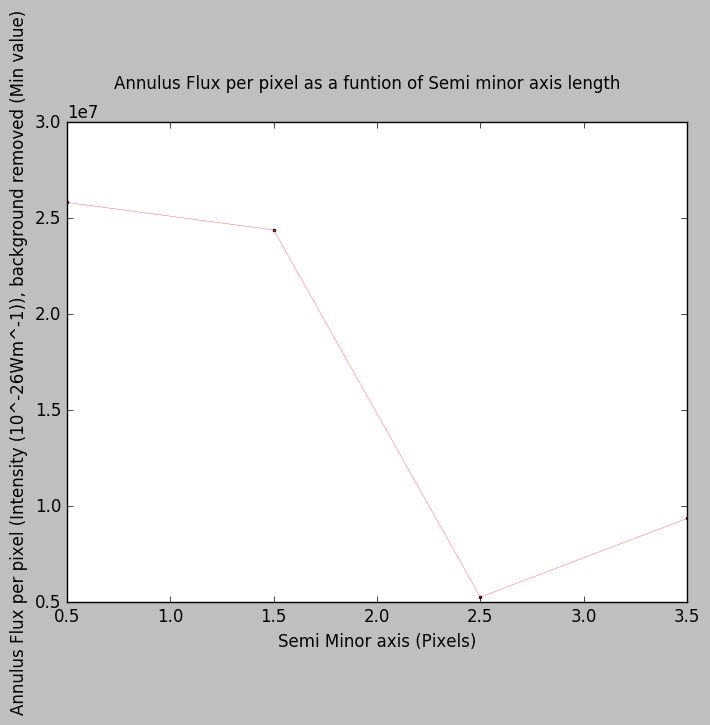

increment of major axis is: 1.1791784033620965
Stop before major is: 16.16099658518028
Stop before minor is: 13.705302386052637
[2646906179.4252839, 2535635326.9233994, 2153422442.0451889, 1755402783.4459336, 1335056087.6839223, 963480917.08033109, 662502044.94848895, 434031461.18343467, 277447026.49042416, 173214235.57604665, 103697864.30903468, 54965573.77393885, 25160943.01842919, 8705591.8300458286]
This is galaxy: 14


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


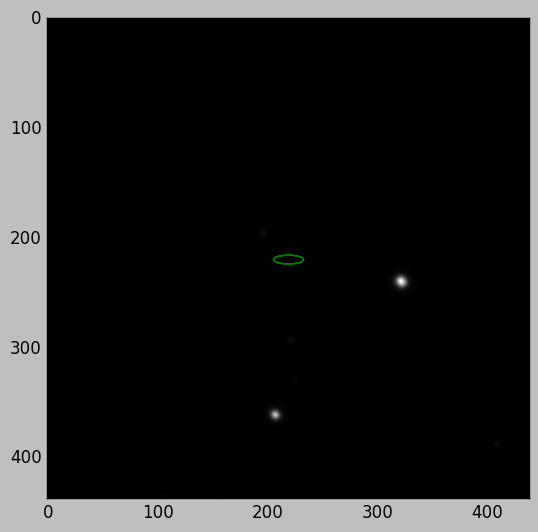

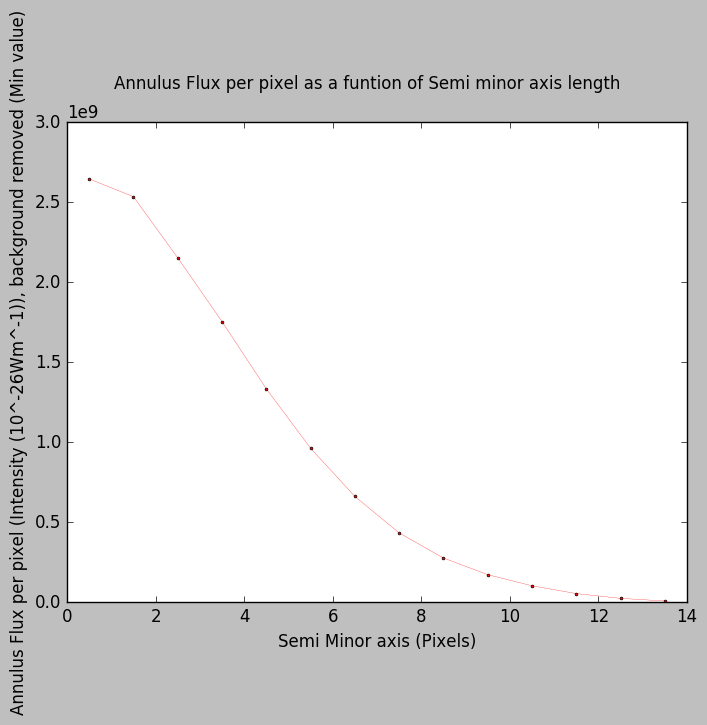

increment of major axis is: 1.0
Stop before major is: 26.745454545454546
Stop before minor is: 26.745454545454546
[15079468330.628572, 13813018075.392487, 11512146692.679913, 8859873100.0090008, 6521395252.2784433, 4755119429.7066498, 3426372643.4556775, 2477182828.8396907, 1820982256.7247412, 1379491213.0344667, 1053737780.6721717, 826475768.75640309, 665542999.92610478, 537292444.63989246, 434384899.51436573, 357370626.83884412, 299147395.684389, 250723066.33973369, 216678153.87823391, 196582576.57721868, 183096179.55504099, 164826187.80216876, 146376346.17706954, 120824694.59848092]
This is galaxy: 15


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


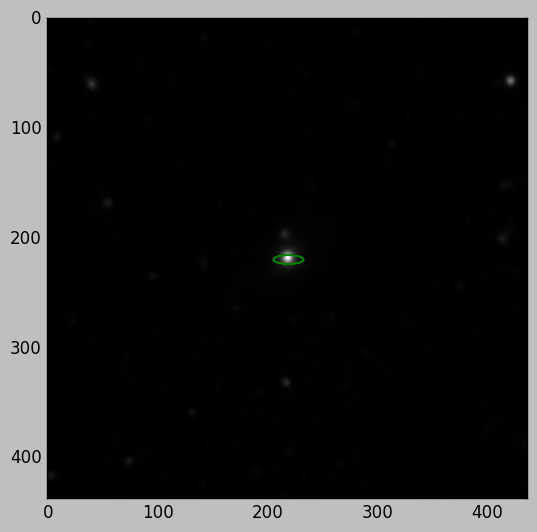

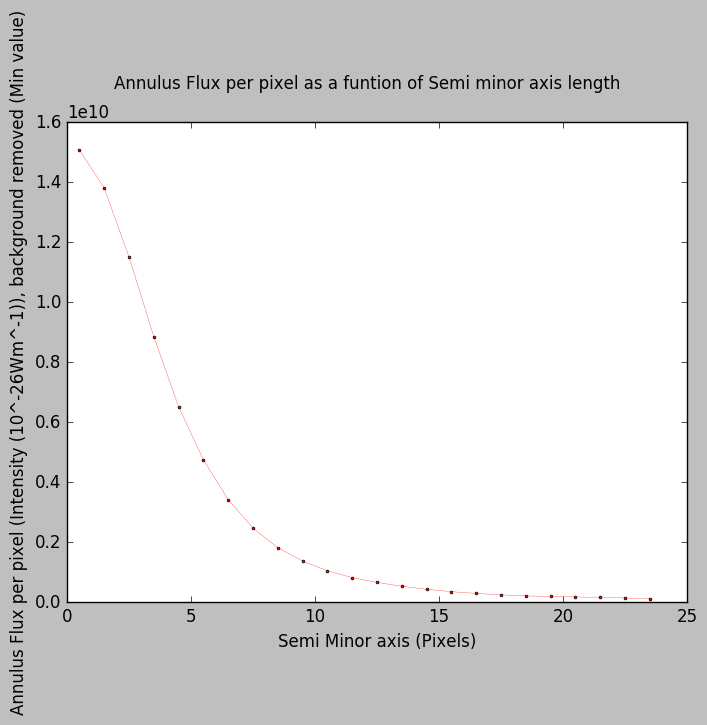

increment of major axis is: 1.0
Stop before major is: 27.181818181818183
Stop before minor is: 27.181818181818183
[-86705115.976916805, -94417478.942521393, -89587858.203297585, -84047313.082956001, -81293379.125465214, -79002894.192450792, -83934895.020312816, -85486057.186688527, -91306605.53955847, -97493999.031556219, -100407978.43909004, -110608947.96671639, -109124941.3227078, -113694176.69967017, -115628506.58616319, -116171815.49837179, -120517185.73776355, -116680838.06229065, -117978765.27571462, -117643259.44305225, -113306906.95619456, -113906427.67394955, -111802471.0842635, -112804126.20443773, -114102587.63276282]
This is galaxy: 16


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


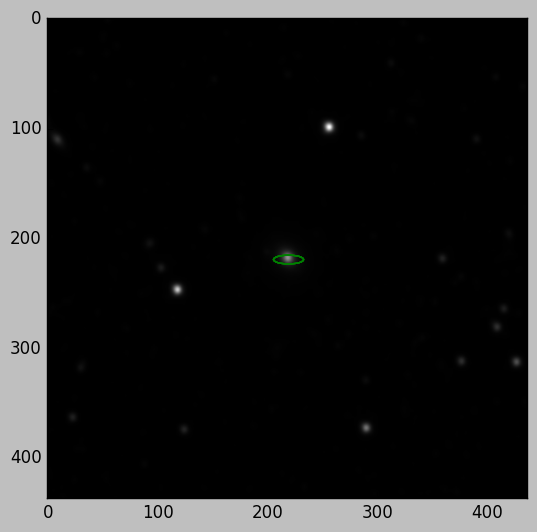

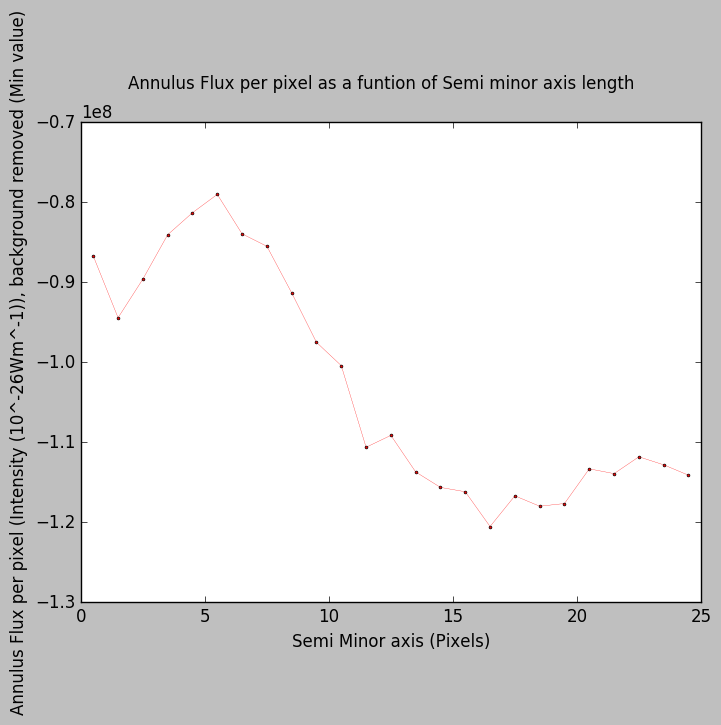

increment of major axis is: 1.414213562373095
Stop before major is: 146.86875901691857
Stop before minor is: 103.85189544531602


Exception ignored in: 'photutils.geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
ZeroDivisionError: float division


[-98152715.630170584, -96690593.038475871, -99342478.96300517, -96770530.838201776, -94518459.626487002, -86046399.488580063, -72003330.360564694, -54448885.983868048, -32668700.512591045, -2726361.1860210211, 42252262.990970068, 100538809.78181611, 176542401.67455557, 267019381.07268527, 353341714.36651623, 413447310.91534716, 424394924.48994195, 375986586.82329965, 285036439.37666488, 183539129.50074691, 96157484.703388765, 32566698.332478784, -6959279.7336443765, -25747558.653354116, -31406981.731853738, -29490938.594421033, -8545326.0036548208, 32760587.196357783, 106011482.66751695, 235042139.11591092, 452198061.2584272, 802092545.89665604, 1314555528.4128089, 1972738748.7160728, 2590575737.3027034, 2951309325.3173661, 2897184640.9139171, 2455050738.0186744, 1816155057.8625345, 1211608367.9264469, 780753076.36233246, 510655204.21082991, 344641601.30531502, 230261789.36491621, 139886250.74471229, 62944698.774965145, 1721301.2314345774, -43524133.375318266, -73019545.555549011, -916

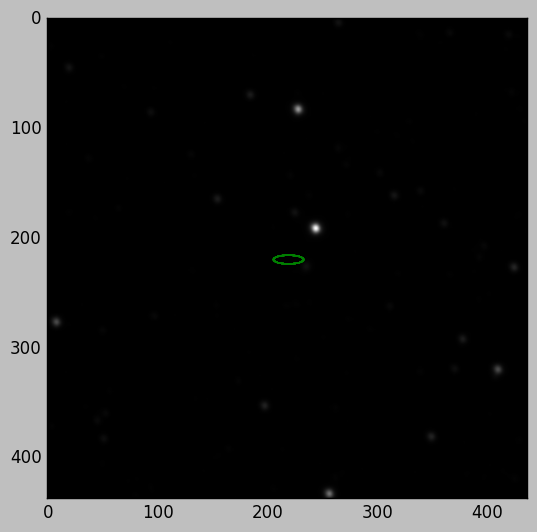

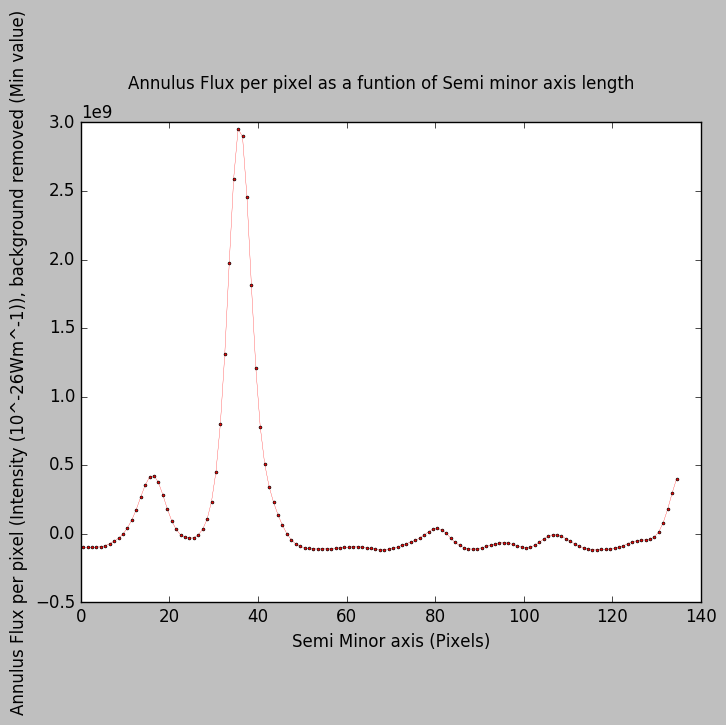

In [44]:
#Graphs of Change of flux per pixel vs radius

for i in arrmgePic:
    image_file = '/mnt/alt43-XDrive/Physics/Projects/MPhys Projects/2016-17/Gas Dust Galaxies/All Data/WISE/%d%c/%d%c/%d%c/%d%cW%iPic.fits' % (i, letter, i, letter, i, letter, i, letter, band)
    hdu_list = fits.open(image_file)
    image_data = hdu_list[0].data
    hdu_list.close()
    image_dataMin[i-1]=np.min(image_data)
    pixels = image_data.shape[0]*image_data.shape[1]
    image_dataPix[i-1]=pixels
    flat_image = list(image_data.flat)
    total = 0
    for l in range(pixels):
        total = total + flat_image[l]
    Ave=total/pixels

   
    RadArray=[]
        
    AnnulusFlux=[]
    DeltaFluxAtRad=[]
    
    b=1
    
    if letter == 'a':
        
        ratioA=GalAMajAxis[i-1]/GalAMinAxis[i-1]
        #print("increment of major axis is:", ratioA)
        
        toprangeA=GalAMajAxis[i-1]+ratioA
        #print("Stop before major axis is:",  toprangeA)
             
        #print("Stop before minor is:", GalAMinAxis[i-1]+1)
        
        rad=ratioA
           
        
        while rad < toprangeA:
            position = [(GalAPixCentreXVal[i-1],GalAPixCentreYVal[i-1])] #Aperture centre around the image centre
            annulus_apertures = EllipticalAnnulus(position, a_in=rad-ratioA, a_out=rad, b_out=b, theta=((GalAPA[i-1])*(np.pi/180)))                   #Aperture at the position chosen
            image_dataAve[i-1]=Ave*ChosenBandCorrectionFactor
            data = image_data
            phot_table = aperture_photometry(data, annulus_apertures, method='subpixel', subpixels=10)
            annulus_area=annulus_apertures.area()
            photsum[i-1] = phot_table
            AnnulusFlux.append((((phot_table[0][0])-(Backgroundlevels[i-1]*annulus_area))*ChosenBandCorrectionFactor)/annulus_area)
            RadArray.append(b-.5)
            rad=rad+ratioA
            b=b+1
            plt.figure(1)
            plt.imshow(image_data, cmap='gray')
            if b % 5 == 0:
                apertures.plot(color='green')
    else:
        ratioB=GalBMajAxis[i-1]/GalBMinAxis[i-1]
        print("increment of major axis is:", ratioB)
        
        toprangeB=GalBMajAxis[i-1]+ratioB
        print("Stop before major is:",  toprangeB)
        
        print("Stop before minor is:", GalBMinAxis[i-1]+1)
        
        rad=ratioB
      
        while rad < toprangeB:
            position = [(GalAPixCentreXVal[i-1],GalAPixCentreYVal[i-1])] #Aperture centre around the image centre
            annulus_apertures = EllipticalAnnulus(position, a_in=rad-ratioB, a_out=rad, b_out=b, theta=((GalBPA[i-1])*(np.pi/180)))                   #Aperture at the position chosen
            image_dataAve[i-1]=Ave*ChosenBandCorrectionFactor
            data = image_data
            phot_table = aperture_photometry(data, annulus_apertures, method='subpixel', subpixels=10)
            annulus_area=annulus_apertures.area()
            photsum[i-1] = phot_table
            AnnulusFlux.append((((phot_table[0][0])-(Backgroundlevels[i-1]*annulus_area))*ChosenBandCorrectionFactor)/annulus_area)
            RadArray.append(b-.5)
            rad=rad+ratioA
            b=b+1
            plt.figure(1)
            plt.imshow(image_data, cmap='gray')
            if b % 5 == 0:
                apertures.plot(color='green')
            
            
    #print(RadArray)
    print(AnnulusFlux)
       
    print("This is galaxy:", i)
    plt.figure(2)
    y1 = AnnulusFlux
    x= RadArray
    #plt.errorbar(x, y5A, xerr=(0.5, 0.7, 5.2, 3), ecolor='black', capthick=1.0, lw=1)
    line = plt.plot(x, y1, 'ro-', linewidth=0.2, ms=2)
    plt.suptitle("Annulus Flux per pixel as a funtion of Semi minor axis length")
    plt.xlabel('Semi Minor axis (Pixels)')
    plt.ylabel('Annulus Flux per pixel (Intensity (10^-26Wm^-1)), background removed (Min value)')
    #labels = ['', '','','','5', '', '', '','','10','', '','','','15', '', '', '','','20','', '','','','25', '', '', '','','30','', '','','','35', '', '', '','','40','', '','','','45', '', '', '','','50','', '','','','55', '', '', '','','60','', '','','','65', '', '', '','','70','', '','','','75', '', '', '','','80','', '','','','85','','','','','90','', '','','','95', '', '', '','','100']
    #plt.xticks(x, labels, rotation='vertical')

    plt.show()

#### Finding the change as a function of increasing distance from the galactic centre required producing an elliptical annulus on top of the galaxy. The annulus area multiplied by the background level is subtracted from the total flux and then this difference is plotted for each annulus extending out from the centre with larger major axis each time at a constant ratio. 